<a href="https://colab.research.google.com/github/Winniewrites/carbonwork/blob/main/zowasel_gee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap pycrs  --upgrade gdown

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=c09bfa5f49aa792c0949e01589728ab578052c5e94ff959803fb9e9781e1a758
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built pycrs
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


**Import required modules**

In [ ]:
import ee
import geemap
import gdown
import pandas as pd
from pathlib import Path
from sklearn.model_selection import GridSearchCV

### Cloud masking

In [ ]:
def se2mask(image):
    quality_band = image.select('QA60')
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    return image.updateMask(mask).divide(10000)

##**Reading Area of intrest (AOI) Data**

**Downloading *(AOI)* as geojson**


In [ ]:
AOI_id = '12Zl0qFsqQbnezMAzZ-bBwFLEikgrE9cg'
url = f'https://drive.google.com/uc?id={AOI_id}'

# Download the file
AOI = gdown.download(url, 'AOI.geojson')

Downloading...
From: https://drive.google.com/uc?id=12Zl0qFsqQbnezMAzZ-bBwFLEikgrE9cg
To: /content/AOI.geojson
100%|██████████| 477/477 [00:00<00:00, 561kB/s]


**Reading (AOI) propeties/Attributes**

In [ ]:
Map = geemap.Map()
# Load GeoJSON file as an Earth Engine FeatureCollection
ROI = geemap.geojson_to_ee(AOI)
ROI.getInfo()

{'type': 'FeatureCollection',
 'columns': {'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'geodesic': False,
    'type': 'MultiPolygon',
    'coordinates': [[[[5.630922314499937, 6.279573505099757],
       [6.40000925739534, 6.282318853689209],
       [6.401566940588752, 5.78308440102448],
       [5.632366485925193, 5.779862388552224],
       [5.630922314499937, 6.279573505099757]]]]},
   'id': '0',
   'properties': {}}]}

**Getting Area for the area of intrest**

In [ ]:
Area = ROI.geometry().area(1)
area_sq_km = Area.divide(1000 * 1000)
print(area_sq_km.getInfo())

4723.712530206857


# **Sample1 tranining Supervised Classification**



### **Acquiring sentinel 2 image for the AOI** -2022

In [ ]:
# #year 2022 ? 2020
# image1 = ee.ImageCollection('COPERNICUS/S2') \
#     .filterBounds(ROI) \
#     .filterDate('2020-01-01', '2020-12-30') \
#     .sort('CLOUDY_PIXEL_PERCENTAGE') \
#     .first() \
#     .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12']) \
#     .clip(ROI)
# image1.getInfo()

image1 = ee.ImageCollection('COPERNICUS/S2') \
      .filterDate("2021-01-01","2021-12-31") \
      .filterBounds(ROI) \
      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",10)).map(se2mask).median()\
      .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12']) \
      .clip(ROI)
image1.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B6',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B7',
   'data_type': {'

### **Sample1 NDVI**

In [ ]:
#calculating NDVI
sample1_ndvi = image1.normalizedDifference(['B8', 'B4']).rename('NDVI')
image1 = image1.addBands(sample1_ndvi)
sample1_ndvi.getInfo()

{'type': 'Image',
 'bands': [{'id': 'NDVI',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

**Getting NDVI Mean for sample 1**

### **Sample1 Digital Elevation Model (DEM)**

In [ ]:
dem = ee.Image('USGS/SRTMGL1_003') \
    .clip(ROI) \
    .rename('DEM')  # Example SRTM DEM data
image1 = image1.addBands(dem)
dem.getInfo()

{'type': 'Image',
 'bands': [{'id': 'DEM',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -32768,
    'max': 32767},
   'dimensions': [1296001, 417601],
   'crs': 'EPSG:4326',
   'crs_transform': [0.0002777777777777778,
    0,
    -180.0001388888889,
    0,
    -0.0002777777777777778,
    60.00013888888889]}],
 'id': 'USGS/SRTMGL1_003',
 'version': 1641990767055141,
 'properties': {'system:visualization_0_min': '0.0',
  'type_name': 'Image',
  'keywords': ['dem',
   'elevation',
   'geophysical',
   'nasa',
   'srtm',
   'topography',
   'usgs'],
  'thumb': 'https://mw1.google.com/ges/dd/images/SRTM90_V4_thumb.png',
  'description': '<p>The Shuttle Radar Topography Mission (SRTM, see <a href="https://onlinelibrary.wiley.com/doi/10.1029/2005RG000183/full">Farr\net al. 2007</a>)\ndigital elevation data is an international research effort that\nobtained digital elevation models on a near-global scale. This\nSRTM V3 product (SRTM Plus) is provided by NASA JPL\nat 


### **Sample1 Enhanced Vegetation Index (EVI)**

$EVI = G * \frac{{NIR -RED}}{{NIR+C_1*RED-C_2*BLUE+L}}$

Where:
- NIR is Near-Infrared band(B8)
- RED is Red band(B4)
- BLUE is Blue band(B2)
- G is gain factor(typically 2.5)
- $C_1$ and $C_2$ are the coefficients of the aerosol resistnace term(typically 6 and 7.5, respectively)
- L is the canopy background adjustment factor( typically 1).


In [ ]:
# Calculate EVI
evi = image1.expression(
    '2.5 * ((NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1))',
    {
        'NIR': image1.select('B8'),  # Near-Infrared band
        'Red': image1.select('B4'),  # Red band
        'Blue': image1.select('B2')  # Blue band
    }
).rename('EVI')

# Add EVI band to the image
image1 = image1.addBands(evi)
evi.getInfo()

{'type': 'Image',
 'bands': [{'id': 'EVI',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

### **Normalized Difference Bareness Index (NDBaI)**
$NDBal = \frac{{SWIR - NIR}}{{SWIR + NIR}}$

where:
- SWIR is the ShortWave-Infrared band(B11)
- NIR is the Near-nfrared band band(B8)


In [ ]:
# ndbai = image1.expression(
#   '(SWIR - NIR) / (SWIR + NIR)', {
#     'SWIR': image1.select('B11'),  #Short-Wave Infrared
#     'NIR': image1.select('B8')   # Near-Infrared
# }).rename('NDBaI')

# image1 = image1.addBands(ndbai)
# ndbai.getInfo()

### **Normalized Difference Water Index (NDWI)**
$NDWl = \frac{{NIR - SWIR}}{{NIR + SWIR}}$

where:
- SWIR is the ShortWave-Infrared band(B11)
- NIR is the Near-nfrared band band(B8)


In [ ]:
ndwi = image1.expression(
  '(NIR - SWIR) / (NIR + SWIR)', {
    'NIR': image1.select('B8'),   # Near-Infrared
    'SWIR': image1.select('B11')  #Short-Wave Infrared
}).rename('NDWI')

image1 = image1.addBands(ndwi)
ndwi.getInfo()

{'type': 'Image',
 'bands': [{'id': 'NDWI',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

### **Soil Adjusted Vegetation Index (SAVI)**

$SAVI = (1 + L) * \frac{{NIR -RED}}{{NIR + RED + L}}$

Where:
- NIR is the Near-Infreared band(B8)
- RED is the Red band(B4)
- L is the canopy background adjustment factor(typically 0.5)

In [ ]:
savi = image1.expression(
  '(NIR - RED) / (NIR + RED + L) * (1 + L)', {
    'NIR': image1.select('B8'),  # Near-Infrared
    'RED': image1.select('B4'),  # Red
    'L': 0.5  # Soil adjustment factor
}).rename('SAVI')

image1 = image1.addBands(savi)
savi.getInfo()

{'type': 'Image',
 'bands': [{'id': 'SAVI',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -19.660500526428223,
    'max': 19.660500526428223},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

### **Green Normalized Difference Vegetation Index (GNDVI)**

$GNDVI =  \frac{{NIR -GREEN}}{{NIR + GREEN}}$

Where:
- NIR is the Near-Infreared band(B8)
- GREEN is the Red band(B3)


In [ ]:
gndvi = image1.expression(
  '(NIR - GREEN) / (NIR + GREEN)', {
    'NIR': image1.select('B8'),  # Near-Infrared

    'GREEN': image1.select('B3'),  # Green
}).rename('GNDVI')

image1 = image1.addBands(gndvi)
gndvi.getInfo()

{'type': 'Image',
 'bands': [{'id': 'GNDVI',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

### **Chlorophyll Vegetation Index (CVI)**

$CVI =  \frac{{NIR}} {{GREEN}} * \frac{{RED}}{{ GREEN}}$

Where:
- NIR is the Near-Infreared band(B8)
- GREEN is the Red band(B3)
- RED is the Red band(B4)

In [ ]:
cvi = image1.expression(
  '(NIR * RED) / (GREEN * GREEN)', {
    'NIR': image1.select('B8'),  # Near-Infrared
    'RED': image1.select('B4'), # Red
    'GREEN': image1.select('B3'),  # Green
}).rename('CVI')

image1 = image1.addBands(cvi)
cvi.getInfo()

{'type': 'Image',
 'bands': [{'id': 'CVI',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

### **Land Surface Temperature (LST)**

In [ ]:
dataset = ee.ImageCollection('MODIS/061/MOD11A1').filter(ee.Filter.date('2022-01-01', '2022-12-30'))
landSurfaceTemperature = dataset.select('LST_Day_1km')
lst_clipped = landSurfaceTemperature.mean().clip(ROI).rename('LST')
image1 = image1.addBands(lst_clipped)
lst_clipped.getInfo()

{'type': 'Image',
 'bands': [{'id': 'LST',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

### **Map Viz**
**Setting visualization parameters**

*   **bands** : the Blue (B2), Green (B3), and Red (B4) bands
*   **min - max** : minimum and maximum values for display
*   **gamma** :  Adjusts the brightness of the image
*  **Sentinel-2 2020** : A string representing the name of the layer

In [ ]:
vis_params = {
    'bands': ['B2', 'B3', 'B4'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

Map.addLayer(image1, vis_params, "Sentinel-2 2020")
Map.centerObject(ROI, 10)

# Map

### **Training Datasets**
**Getting Training Dataset as geojson file**

In [ ]:
training_id = '14Hcwr4a4JR_usqxnjHyUWf_zGP6F078x'
training_url = f'https://drive.google.com/uc?id={training_id}'
# Download the file
tr = gdown.download(training_url, 'Training_Data.geojson')
training_data = geemap.geojson_to_ee(tr)
training_data.getInfo()

Downloading...
From: https://drive.google.com/uc?id=14Hcwr4a4JR_usqxnjHyUWf_zGP6F078x
To: /content/Training_Data.geojson
100%|██████████| 56.5k/56.5k [00:00<00:00, 2.93MB/s]


Could not convert the geojson to ee.Geometry()


Exception: Earth Engine client library not initialized. Run `ee.Initialize()`

**Displaying the Training data set on a map**

In [ ]:
samples = training_data
Map.addLayer(samples, {}, 'training', False)

**Training data properties**

In [ ]:
samples.size().getInfo()

395

In [ ]:
samples.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [5.87993142657977, 6.234991598817783]},
 'id': '0',
 'properties': {'Class': 4}}

#### **test-train split**
**Splitting the the training dataset in test and training**

*   validation data 20%
*   tratining data 80%



In [ ]:
# Use these bands for prediction.
# bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12', 'NDVI', 'DEM', 'EVI', 'NDBaI', 'NDWI', 'SAVI','LST']
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B8','B11','B12', 'NDVI', 'DEM', 'NDWI', 'SAVI','GNDVI','CVI','LST']

# This property stores the land cover labels.
label = 'Class'

# Overlay the points on the imagery to get training.
sample1 = image1.select(bands).sampleRegions(**{
  'collection': samples,
  'properties': [label],
  'scale': 10
})

# Adds a column of deterministic pseudorandom numbers.
sample1 = sample1.randomColumn()

split = 0.8

training1 = sample1.filter(ee.Filter.lt('random', split))
validation1 = sample1.filter(ee.Filter.gte('random', split))

In [ ]:
training1.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0_0',
 'properties': {'B11': 0.21025000512599945,
  'B12': 0.13064999878406525,
  'B2': 0.1344500035047531,
  'B3': 0.12035000324249268,
  'B4': 0.1152999997138977,
  'B5': 0.1274999976158142,
  'B6': 0.18825000524520874,
  'B8': 0.21125000715255737,
  'CVI': 1.6816431283950806,
  'Class': 4,
  'DEM': 45,
  'GNDVI': 0.27412545680999756,
  'LST': 15319.41935483871,
  'NDVI': 0.29382944107055664,
  'NDWI': 0.002372483955696225,
  'SAVI': 0.17412740906460766,
  'random': 0.09451495879782668}}

In [ ]:
validation1.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '10_0',
 'properties': {'B11': 0.22450000047683716,
  'B12': 0.1559000015258789,
  'B2': 0.14669999480247498,
  'B3': 0.1278499960899353,
  'B4': 0.11774999648332596,
  'B5': 0.12880000472068787,
  'B6': 0.21979999542236328,
  'B8': 0.24160000681877136,
  'CVI': 1.740429401397705,
  'Class': 4,
  'DEM': 49,
  'GNDVI': 0.3078901469707489,
  'LST': 15299.766666666666,
  'NDVI': 0.3446500897407532,
  'NDWI': 0.036687418818473816,
  'SAVI': 0.21618085156143352,
  'random': 0.8298134052844777}}

### **Train a 100-tree random forest classifier from the training sample.**

In [ ]:
# Train a CART classifier with default parameters.
# trained1 = ee.Classifier.smileCart().train(training1, label, bands)
trained1 = ee.Classifier.smileRandomForest(70).train(training1, label, bands)

### **Classifing Our image with trained model**

In [ ]:
# Classify the image with the same bands used for training.
result1 = image1.select(bands).classify(trained1)

In [ ]:
# # Display the clusters with random colors.
Map.addLayer(result1.randomVisualizer(), {}, 'classfied')

In [ ]:
legend_keys = ['Wetland', 'BuiltupArea', 'Forest','Cropland','Grassland', 'Bareland']
legend_colors = ['#24ffd4', '#73198b', '#09460d', '#52a441','#86e616', '#864027']


# Remap the classified image
result1 = result1.remap([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5,6])


Map.addLayer(result1, {'min': 1, 'max': 6, 'palette': legend_colors}, 'Labelled lancover 2020')
Map.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')

In [ ]:
Map

Map(center=[6.031209945643237, 6.016154683756821], controls=(WidgetControl(options=['position', 'transparent_b…

### **Accuracy Assessment of Training Dataset**

**Confusion Matrix**

In [ ]:
train_accuracy = trained1.confusionMatrix()


In [ ]:
train_accuracy.getInfo()

[[95, 0, 0, 0, 0, 0],
 [0, 66, 0, 0, 0, 0],
 [0, 0, 36, 0, 0, 0],
 [0, 0, 0, 41, 0, 0],
 [0, 0, 0, 1, 36, 0],
 [0, 1, 0, 0, 0, 41]]

**Feature importance**

In [ ]:
# Feature importance
importance = ee.Dictionary(trained1.explain().get('importance'))

# Calculate the sum of importance values
sum_importance = importance.values().reduce(ee.Reducer.sum())

# Convert absolute importance to relative importance
def to_relative_importance(key, val):
    return ee.Number(val).multiply(100).divide(sum_importance)

relative_importance = importance.map(to_relative_importance)

# Convert the Earth Engine Dictionary to a FeatureCollection for visualization
importance_fc = ee.FeatureCollection([
    ee.Feature(None, relative_importance)
])


# Convert to pandas DataFrame for easier handling and visualization
importance_dict = relative_importance.getInfo()  # This converts the EE dictionary to a Python dict
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Variable', 'Relative Importance'])

# Sort the DataFrame based on importance
df_importance = df_importance.sort_values(by='Relative Importance', ascending=False)

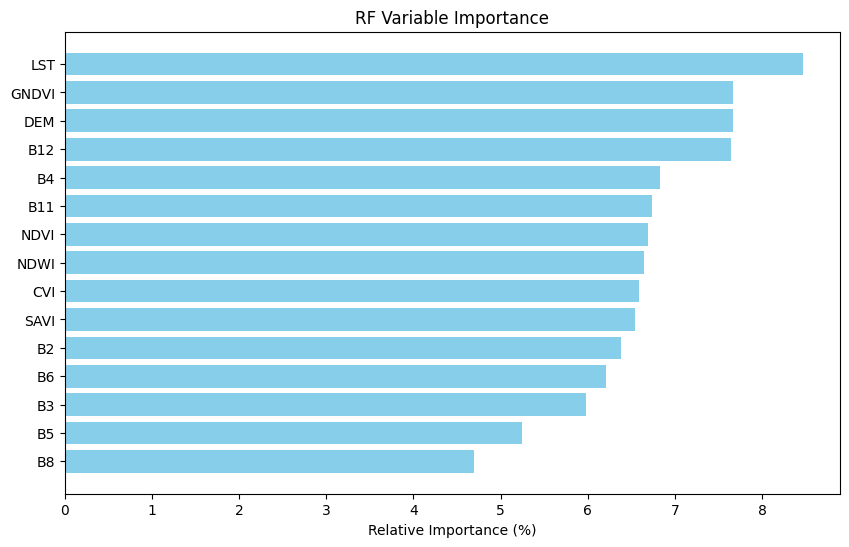

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(df_importance['Variable'], df_importance['Relative Importance'], color='skyblue')
plt.xlabel('Relative Importance (%)')
plt.title('RF Variable Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

Do dropping B7 and NDBal, do they improve test accuracy? - Yes increased accuracy from 84 to 89


**Overall Accuracy**

In [ ]:
train_accuracy.accuracy().getInfo()

0.9936908517350158

**Kappa Coefficient**

In [ ]:
train_accuracy.kappa().getInfo()

0.9921699394837594

**Producer's Accuracy**

In [ ]:
train_accuracy.producersAccuracy().getInfo()

[[1], [1], [1], [1], [0.972972972972973], [0.9761904761904762]]

**Consumer's Accuracy**

In [ ]:
train_accuracy.consumersAccuracy().getInfo()

[[1, 0.9850746268656716, 1, 0.9761904761904762, 1, 1]]

### **Accuracy assessment of Validation Dataset**

**Classify the validation area based on the same trained classifier**

In [ ]:
validated = validation1.classify(trained1)

In [ ]:
validated.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '10_0',
 'properties': {'B11': 0.22450000047683716,
  'B12': 0.1559000015258789,
  'B2': 0.14669999480247498,
  'B3': 0.1278499960899353,
  'B4': 0.11774999648332596,
  'B5': 0.12880000472068787,
  'B6': 0.21979999542236328,
  'B8': 0.24160000681877136,
  'CVI': 1.740429401397705,
  'Class': 4,
  'DEM': 49,
  'GNDVI': 0.3078901469707489,
  'LST': 15299.766666666666,
  'NDVI': 0.3446500897407532,
  'NDWI': 0.036687418818473816,
  'SAVI': 0.21618085156143352,
  'classification': 4,
  'random': 0.8298134052844777}}

**Error Matrix**

In [ ]:
test_accuracy = validated.errorMatrix(label, 'classification')

In [ ]:
test_accuracy.getInfo()

[[25, 0, 0, 0, 0, 0],
 [0, 23, 0, 0, 0, 0],
 [0, 0, 8, 0, 0, 0],
 [0, 0, 1, 10, 0, 0],
 [0, 0, 0, 0, 8, 0],
 [0, 0, 0, 0, 0, 9]]

**Overall Accuracy**

In [ ]:
test_accuracy.accuracy().getInfo()

0.9880952380952381

**Kappa Coefficient**

In [ ]:
test_accuracy.kappa().getInfo()

0.984932735426009

**Producer's Accuracy**

In [ ]:
test_accuracy.producersAccuracy().getInfo()

[[1], [1], [1], [0.9090909090909091], [1], [1]]

**Consumer's Accuracy**

In [ ]:
test_accuracy.consumersAccuracy().getInfo()

[[1, 1, 0.8888888888888888, 1, 1, 1]]

### **Export the image results**

In [ ]:
# geemap.ee_export_image(result1, filename='output_image', scale=30)

# **Sample 2**

### **Acquiring sentinel 2 image for the AOI and adding indicies** - YEAR 2017


In [ ]:
# Year 2017
# image2 = ee.ImageCollection('COPERNICUS/S2') \
#     .filterBounds(ROI) \
#     .filterDate('2021-01-01', '2021-12-30') \
#     .sort('CLOUDY_PIXEL_PERCENTAGE') \
#     .first() \
#     .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12']) \
#     .clip(ROI)
# image2.getInfo()

image2 = ee.ImageCollection('COPERNICUS/S2') \
      .filterDate("2017-01-01","2017-12-31") \
      .filterBounds(ROI) \
      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",10)).map(se2mask).median()\
      .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12']) \
      .clip(ROI)
image2.getInfo()


{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B6',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B7',
   'data_type': {'

In [ ]:
#calculating NDVI
sample2_ndvi = image1.normalizedDifference(['B8', 'B4']).rename('NDVI')
image2 = image2.addBands(sample2_ndvi)
sample2_ndvi.getInfo()

{'type': 'Image',
 'bands': [{'id': 'NDVI',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [ ]:
#mean NDVI for sample 2 image
sample2_mean_ndvi = (image2
             .select('NDVI')
             .reduceRegion(reducer=ee.Reducer.mean(),
                           geometry= ROI,
                           scale=10,
                           maxPixels=1e10))
sample2_mean_ndvi.getInfo()

{'NDVI': 0.3897243020411545}

In [ ]:
#Adding DEM to a sample 2
image2 = image2.addBands(dem)

In [ ]:
# Calculate EVI
evi2 = image2.expression(
    '2.5 * ((NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1))',
    {
        'NIR': image2.select('B8'),  # Near-Infrared band
        'Red': image2.select('B4'),  # Red band
        'Blue': image2.select('B2')  # Blue band
    }
).rename('EVI')

# Add EVI band to the image
image2 = image2.addBands(evi2)
evi2.getInfo()

{'type': 'Image',
 'bands': [{'id': 'EVI',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [ ]:
#Calculating NDBal
# ndbai2 = image2.expression(
#   '(SWIR - NIR) / (SWIR + NIR)', {
#     'SWIR': image2.select('B11'),  #Short-Wave Infrared
#     'NIR': image2.select('B8')   # Near-Infrared
# }).rename('NDBaI')

# image2 = image2.addBands(ndbai2)
# ndbai2.getInfo()

In [ ]:
ndwi2 = image2.expression(
  '(NIR - SWIR) / (NIR + SWIR)', {
    'NIR': image2.select('B8'),   # Near-Infrared
    'SWIR': image2.select('B11')  #Short-Wave Infrared
}).rename('NDWI')

image2 = image2.addBands(ndwi2)
ndwi2.getInfo()

{'type': 'Image',
 'bands': [{'id': 'NDWI',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [ ]:
#Calculating SAVI
savi2 = image2.expression(
  '(NIR - RED) / (NIR + RED + L) * (1 + L)', {
    'NIR': image2.select('B8'),  # Near-Infrared
    'RED': image2.select('B4'),  # Red
    'L': 0.5  # Soil adjustment factor
}).rename('SAVI')

image2 = image2.addBands(savi2)
savi2.getInfo()

{'type': 'Image',
 'bands': [{'id': 'SAVI',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -19.660500526428223,
    'max': 19.660500526428223},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [ ]:
#Acquiring and adding LST
dataset2 = ee.ImageCollection('MODIS/061/MOD11A1').filter(ee.Filter.date('2017-01-01', '2017-12-30'))
landSurfaceTemperature2 = dataset2.select('LST_Day_1km')
lst_clipped2= landSurfaceTemperature2.mean().clip(ROI).rename('LST')
image2 = image2.addBands(lst_clipped2)
lst_clipped2.getInfo()

{'type': 'Image',
 'bands': [{'id': 'LST',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [ ]:
gndvi2 = image1.expression(
  '(NIR - GREEN) / (NIR + GREEN)', {
    'NIR': image2.select('B8'),  # Near-Infrared

    'GREEN': image2.select('B3'),  # Green
}).rename('GNDVI')

image2 = image2.addBands(gndvi2)
gndvi2.getInfo()

{'type': 'Image',
 'bands': [{'id': 'GNDVI',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [ ]:
cvi2 = image1.expression(
  '(NIR * RED) / (GREEN * GREEN)', {
    'NIR': image1.select('B8'),  # Near-Infrared
    'RED': image1.select('B4'), # Red
    'GREEN': image1.select('B3'),  # Green
}).rename('CVI')

image2 = image2.addBands(cvi2)
cvi2.getInfo()

{'type': 'Image',
 'bands': [{'id': 'CVI',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

### **Classifing Our image with trained model**

In [ ]:
# Classify the image with the same bands used for training.
result2 = image2.select(bands).classify(trained1)


In [ ]:
# Remap the classified image
result2 = result2.remap([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6])

### **Exporting results**

In [ ]:
#exporting the results
# geemap.ee_export_image(result2, filename='output_image2', scale=30)

In [ ]:
result1.getInfo()

{'type': 'Image',
 'bands': [{'id': 'remapped',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 1, 'max': 6},
   'dimensions': [362, 118],
   'origin': [-181, -57],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [ ]:
result2.getInfo()

{'type': 'Image',
 'bands': [{'id': 'remapped',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 1, 'max': 6},
   'dimensions': [362, 118],
   'origin': [-181, -57],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

### **AREA FOR EACH CLASS**

In [ ]:
# out_dir = Path.home() / 'Downloads'
# landcover_stats = out_dir / 'landcover_stats2021.csv'
# # Create the directory if it doesn't exist
# out_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Perform zonal statistics
# stats_result1 = geemap.zonal_statistics_by_group(result1, ROI, landcover_stats, statistics_type='AREA')

In [ ]:
pixel_areas = ee.Image.pixelArea().multiply(1e-6)
image1_with_areas = pixel_areas.addBands(result1)
result1_Area = image1_with_areas.reduceRegion(
    reducer=ee.Reducer.sum().group(1),
    geometry=ROI,
    scale=10,
    bestEffort=True
)

In [ ]:
areas_info = result1_Area.getInfo()['groups']
areas_info

[{'group': 1, 'sum': 56.79317395403964},
 {'group': 2, 'sum': 102.44238121325935},
 {'group': 3, 'sum': 724.705085514817},
 {'group': 4, 'sum': 2791.014180096196},
 {'group': 5, 'sum': 726.5590407738832},
 {'group': 6, 'sum': 301.77135146465776}]

In [ ]:
# # out_dir = Path.home() / 'Downloads'
# landcover_stats2 = out_dir / 'landcover_stats2017.csv'

# # Create the directory if it doesn't exist
# out_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Perform zonal statistics
# stats_result2 = geemap.zonal_statistics_by_group(result2, ROI, landcover_stats2,  statistics_type='AREA')

In [ ]:
df = pd.DataFrame(areas_info)
df

,group,sum
0,1,56.793174
1,2,102.442381
2,3,724.705086
3,4,2791.014180
4,5,726.559041
5,6,301.771351


EEException: Collection query aborted after accumulating over 5000 elements.

In [ ]:
pixel_areas = ee.Image.pixelArea().multiply(1e-6)
image2_with_areas = pixel_areas.addBands(result2)
result2_Area = image2_with_areas.reduceRegion(
    reducer=ee.Reducer.sum().group(1),
    geometry=ROI,
    scale=10,
    bestEffort=True
)

In [ ]:
areas2_info = result2_Area.getInfo()['groups']
areas2_info

### **Land cover change index.**

$ LCI = \frac{{(A_a - A_b) }}{{A_a}}*100 $

Where:
- $A_a $ - represents the area of a particular land cover type in year \( a \),
- $A_b $ - represents the area of the same land cover type in year \( b \),
- $LCI $ - is the Land Cover Change Index.



In [ ]:
# Path to the CSV file
csv_file_path_2017 = '/root/Downloads/landcover_stats2017.csv'
csv_file_path_2021 = '/root/Downloads/landcover_stats2021.csv'

# Read the CSV file into a pandas DataFrame
df_2017 = pd.read_csv(csv_file_path_2017)
df_2021 = pd.read_csv(csv_file_path_2021)

combined_df = pd.concat([df_2017, df_2021], ignore_index=True)
transposed_df = combined_df.transpose()

In [ ]:
transposed_df.columns = ['2017', '2021']
system_index = transposed_df[ (transposed_df['2017'] == 0) & (transposed_df['2021'] == 0) ].index
transposed_df.drop(system_index , inplace=True)
transposed_df

In [ ]:
transposed_df['LCI'] = ((transposed_df['2021'] - transposed_df['2017']) / transposed_df['2017']) * 100
transposed_df

### **Mean NDVI** - 2017,2018,2019,2020,2021

---



In [ ]:
#2017 -start year
image_ndvi_2017 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(ROI) \
    .filterDate('2017-01-01', '2017-12-30') \
    .sort('CLOUDY_PIXEL_PERCENTAGE') \
    .first() \
    .select([ 'B4','B8']) \
    .clip(ROI)

ndvi_2017 = image_ndvi_2017.normalizedDifference(['B8', 'B4']).rename('NDVI')
image_ndvi_2017 = image_ndvi_2017.addBands(ndvi_2017)
mean_ndvi_2017 = (image_ndvi_2017
             .select('NDVI')
             .reduceRegion(reducer=ee.Reducer.mean(),
                           geometry= ROI,
                           scale=10,
                           maxPixels=1e10))
# first_year = mean_ndvi_2017.get('NDVI')

In [ ]:
#2018 - 2nd year
image_ndvi_2018 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(ROI) \
    .filterDate('2018-01-01', '2018-12-30') \
    .sort('CLOUDY_PIXEL_PERCENTAGE') \
    .first() \
    .select([ 'B4','B8']) \
    .clip(ROI)
ndvi_2018 = image_ndvi_2018.normalizedDifference(['B8', 'B4']).rename('NDVI')
image_ndvi_2018 = image_ndvi_2018.addBands(ndvi_2018)
mean_ndvi_2018 = (image_ndvi_2018
             .select('NDVI')
             .reduceRegion(reducer=ee.Reducer.mean(),
                           geometry= ROI,
                           scale=10,
                           maxPixels=1e10))
# second_year = mean_ndvi_2018.get('NDVI')

In [ ]:
#2019 - 3rd year
image_ndvi_2019 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(ROI) \
    .filterDate('2019-01-01', '2019-12-30') \
    .sort('CLOUDY_PIXEL_PERCENTAGE') \
    .first() \
    .select([ 'B4','B8']) \
    .clip(ROI)

ndvi_2019 = image_ndvi_2019.normalizedDifference(['B8', 'B4']).rename('NDVI')
image_ndvi_2019 = image_ndvi_2019.addBands(ndvi_2019)
mean_ndvi_2019 = (image_ndvi_2019
             .select('NDVI')
             .reduceRegion(reducer=ee.Reducer.mean(),
                           geometry= ROI,
                           scale=10,
                           maxPixels=1e10))
# third_year = mean_ndvi_2019.get('NDVI')

In [ ]:
#2020 - 4th year
image_ndvi_2020 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(ROI) \
    .filterDate('2020-01-01', '2020-12-30') \
    .sort('CLOUDY_PIXEL_PERCENTAGE') \
    .first() \
    .select([ 'B4','B8']) \
    .clip(ROI)
ndvi_2020 = image_ndvi_2020.normalizedDifference(['B8', 'B4']).rename('NDVI')
image_ndvi_2020 = image_ndvi_2020.addBands(ndvi_2020)
mean_ndvi_2020 = (image_ndvi_2020
             .select('NDVI')
             .reduceRegion(reducer=ee.Reducer.mean(),
                           geometry= ROI,
                           scale=10,
                           maxPixels=1e10))
# forth_year = mean_ndvi_2020.get('NDVI')

In [ ]:
#2021 - 5th n the last year
image_ndvi_2021 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(ROI) \
    .filterDate('2021-01-01', '2021-12-30') \
    .sort('CLOUDY_PIXEL_PERCENTAGE') \
    .first() \
    .select([ 'B4','B8']) \
    .clip(ROI)
ndvi_2021 = image_ndvi_2021.normalizedDifference(['B8', 'B4']).rename('NDVI')
image_ndvi_2021 = image_ndvi_2021.addBands(ndvi_2021)
mean_ndvi_2021 = (image_ndvi_2020
             .select('NDVI')
             .reduceRegion(reducer=ee.Reducer.mean(),
                           geometry= ROI,
                           scale=10,
                           maxPixels=1e10))
# fifth_year = mean_ndvi_2021.get('NDVI')

In [ ]:
average_ndvi = (mean_ndvi_2017.get('NDVI').getInfo() +
                mean_ndvi_2018.get('NDVI').getInfo() +
                mean_ndvi_2019.get('NDVI').getInfo() +
                mean_ndvi_2020.get('NDVI').getInfo() +
                mean_ndvi_2021.get('NDVI').getInfo()
                ) / 5
average_ndvi

### **vegetation carbon storage**

${\Delta}C = LCI per class * Average NDVI$

In [ ]:
transposed_df['Carbon'] = transposed_df['LCI'] * average_ndvi
transposed_df